## 0. Loading Data

In [1]:
import pandas as pd

# Load the CSV file into a DataFrame with low_memory=False to avoid DtypeWarning
data = pd.read_csv('msna_data.csv', low_memory=False)

## 1. Data Exploration

                                           Variable  Pearson Correlation  \
60      child_sep_severity_all_family_reun_required             1.000000   
6                           children_outside_hh_all             0.225001   
5                               children_outside_hh             0.225001   
9                           child_sep_reasons_given             0.225001   
57                      children_outside_hh_all_yes             0.225001   
64                      child_sep_reasons_given_yes             0.225001   
55                          children_outside_hh_yes             0.225001   
148                                   msna_car-2021             0.117745   
77         displ_status_specific_refugee_repatriate             0.079237   
90                              single_caregiver_NA             0.066441   
66                         sep_children_hosting_yes             0.064081   
10                             sep_children_hosting             0.049903   
30          

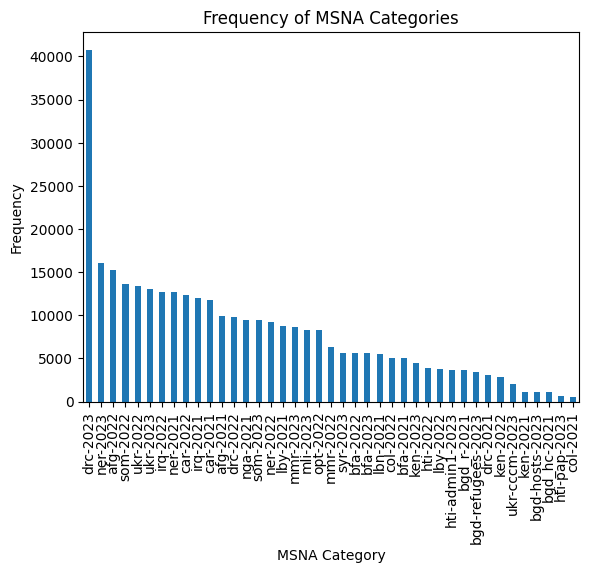

Explanatory Test: Cross-tabulation of msna categories and target values
child_sep_severity_family_reun_required       0.0       1.0
msna                                                       
afg-2021                                 0.999262  0.000738
afg-2022                                 0.999869  0.000131
bfa-2021                                 0.996712  0.003288
bfa-2022                                 0.997073  0.002927
bfa-2023                                 0.997325  0.002675
bgd-hosts-2023                           1.000000  0.000000
bgd-refugees-2023                        0.997026  0.002974
bgd_hc-2021                              0.999040  0.000960
bgd_r-2021                               0.999707  0.000293
car-2021                                 0.958882  0.041118
car-2022                                 0.995492  0.004508
col-2022                                 0.999729  0.000271
drc-2021                                 0.996414  0.003586
drc-2022                    

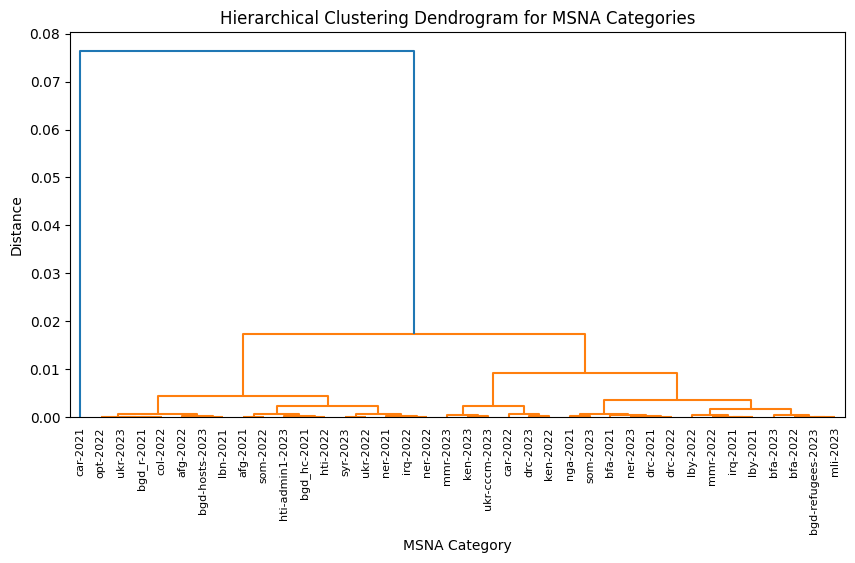

In [2]:
import missingno as msno
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import pearsonr, spearmanr, kendalltau, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pandas as pd

# Label encode any categorical variables to ensure no NaNs during conversion
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns before converting them to numeric
def encode_categorical_columns(df):
    for col in df.select_dtypes(include=['object', 'category']).columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))
    return df

# Apply encoding to categorical columns
encoded_data = encode_categorical_columns(data.copy())

# Now convert to numeric (this step will not introduce NaNs because categorical columns are now encoded)
numeric_data = encoded_data.apply(pd.to_numeric, errors='coerce')

# Function to calculate correlations, p-values, and other explanatory metrics
def explanatory_analysis(df, target):
    variables = df.columns[df.columns != target]
    results = {
        'Variable': [],
        'Pearson Correlation': [],
        'Pearson P-Value': [],
        'Spearman Correlation': [],
        'Spearman P-Value': [],
        'Kendall Tau Correlation': [],
        'Kendall P-Value': [],
        'Skewness': [],
        'Variance Inflation Factor (VIF)': []
    }

    for col in variables:
        clean_df = df[[col, target]].dropna()

        # Check if the column has enough variability (at least 2 unique values)
        if len(clean_df) >= 2 and clean_df[col].nunique() > 1 and clean_df[target].nunique() > 1:
            # Pearson correlation and p-value
            pearson_corr, pearson_p = pearsonr(clean_df[col], clean_df[target])

            # Spearman correlation and p-value (only if there's variability)
            spearman_corr, spearman_p = spearmanr(clean_df[col], clean_df[target]) if clean_df[col].nunique() > 1 else (np.nan, np.nan)

            # Kendall's Tau correlation and p-value (only if there's variability)
            kendall_corr, kendall_p = kendalltau(clean_df[col], clean_df[target]) if clean_df[col].nunique() > 1 else (np.nan, np.nan)

            # Skewness (calculate only if variability exists)
            skewness = skew(clean_df[col]) if clean_df[col].nunique() > 1 else np.nan

            # VIF calculation (handled similarly)
            try:
                vif = variance_inflation_factor(df.dropna().values, df.columns.get_loc(col))
            except:
                vif = np.nan  # Handle cases where VIF cannot be computed

            # Append results to the appropriate lists
            results['Variable'].append(col)
            results['Pearson Correlation'].append(pearson_corr)
            results['Pearson P-Value'].append(pearson_p)
            results['Spearman Correlation'].append(spearman_corr)
            results['Spearman P-Value'].append(spearman_p)
            results['Kendall Tau Correlation'].append(kendall_corr)
            results['Kendall P-Value'].append(kendall_p)
            results['Skewness'].append(skewness)
            results['Variance Inflation Factor (VIF)'].append(vif)

    # Return the results as a DataFrame
    return pd.DataFrame(results).sort_values(by='Pearson Correlation', ascending=False)

# Apply the function for explanatory analysis on all numeric variables
explanatory_table = explanatory_analysis(numeric_data, 'child_sep_severity_family_reun_required')

# Print the explanatory analysis table
print(explanatory_table)

# Export the DataFrame to an Excel file
explanatory_table.to_excel("eda_corr_table.xlsx", index=False)

# Check the frequency of each category in 'msna'
msna_freq = data['msna'].value_counts()

# Print the frequency of each category in msna
print("Frequency of each category in 'msna':")
print(msna_freq)

# Visualize the distribution of msna categories
msna_freq.plot(kind='bar')
plt.title('Frequency of MSNA Categories')
plt.xlabel('MSNA Category')
plt.ylabel('Frequency')
plt.show()

# Cross-tabulation of msna categories and target values
print("Explanatory Test: Cross-tabulation of msna categories and target values")
target_dist_by_msna = pd.crosstab(data['msna'], data['child_sep_severity_family_reun_required'], normalize='index')
print(target_dist_by_msna)

# Check the structure of the input data (proportion of target variable for each msna category)
print("Explanatory Test: Structure of the input data (proportion of target variable for each msna category)")
print(target_dist_by_msna.head())

# Perform hierarchical clustering using the linkage matrix
linkage_matrix = linkage(target_dist_by_msna, method='ward')

# Plot the dendrogram to visualize category clustering
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=target_dist_by_msna.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram for MSNA Categories')
plt.xlabel('MSNA Category')
plt.ylabel('Distance')
plt.show()

## 2. Feature Engineering

### 2.1 Data Cleaning

The data cleaning process begins by removing rows with missing values in the target column, `child_sep_severity`. Next, only the relevant variables from the `vars_analysis.csv` file are retained for further analysis. Columns with more than 20% missing values are dropped to ensure data quality. Additionally, columns with zero variance, which provide no useful information, are removed. Variables ending in '_NA' without corresponding non-NA versions are also discarded to avoid redundancy. Missing data patterns are visualized both before and after these cleaning steps. Finally, the cleaned dataset is reviewed to ensure all essential variables remain, with any dropped variables from `vars_analysis` reported.



Shape of the filtered DataFrame, without missing values for the response variable: (268511, 199)

Dropped columns with more than 20% missing values:
['lcsi_cat', 'hoh_age', 'rcsi_score', 'fsl_fc_cell', 'wgq_dis_4_n', 'wgq_dis_3_n', 'wgq_dis_2_n', 'fatalities_3m', 'events_3m', 'fatalities_6m', 'events_6m', 'fatalities_1y', 'events_1y', 'displ_status_specific_idp_non_site', 'displ_status_specific_idp_returnee', 'displ_status_specific_idp_site', 'received_assistance_3m_dnk', 'received_assistance_3m_dwta', 'received_assistance_3m_no', 'received_assistance_3m_yes', 'received_assistance_6m_dnk', 'received_assistance_6m_dwta', 'received_assistance_6m_no', 'received_assistance_6m_yes', 'received_assistance_12m_dnk', 'received_assistance_12m_dwta', 'received_assistance_12m_no', 'received_assistance_12m_yes']

Dropped columns '_NA' columns:
['displ_status_general_NA', 'displ_status_specific_NA', 'hoh_gender_NA', 'single_caregiver_NA', 'received_assistance_3m_NA', 'received_assistance_6m_NA', 'r

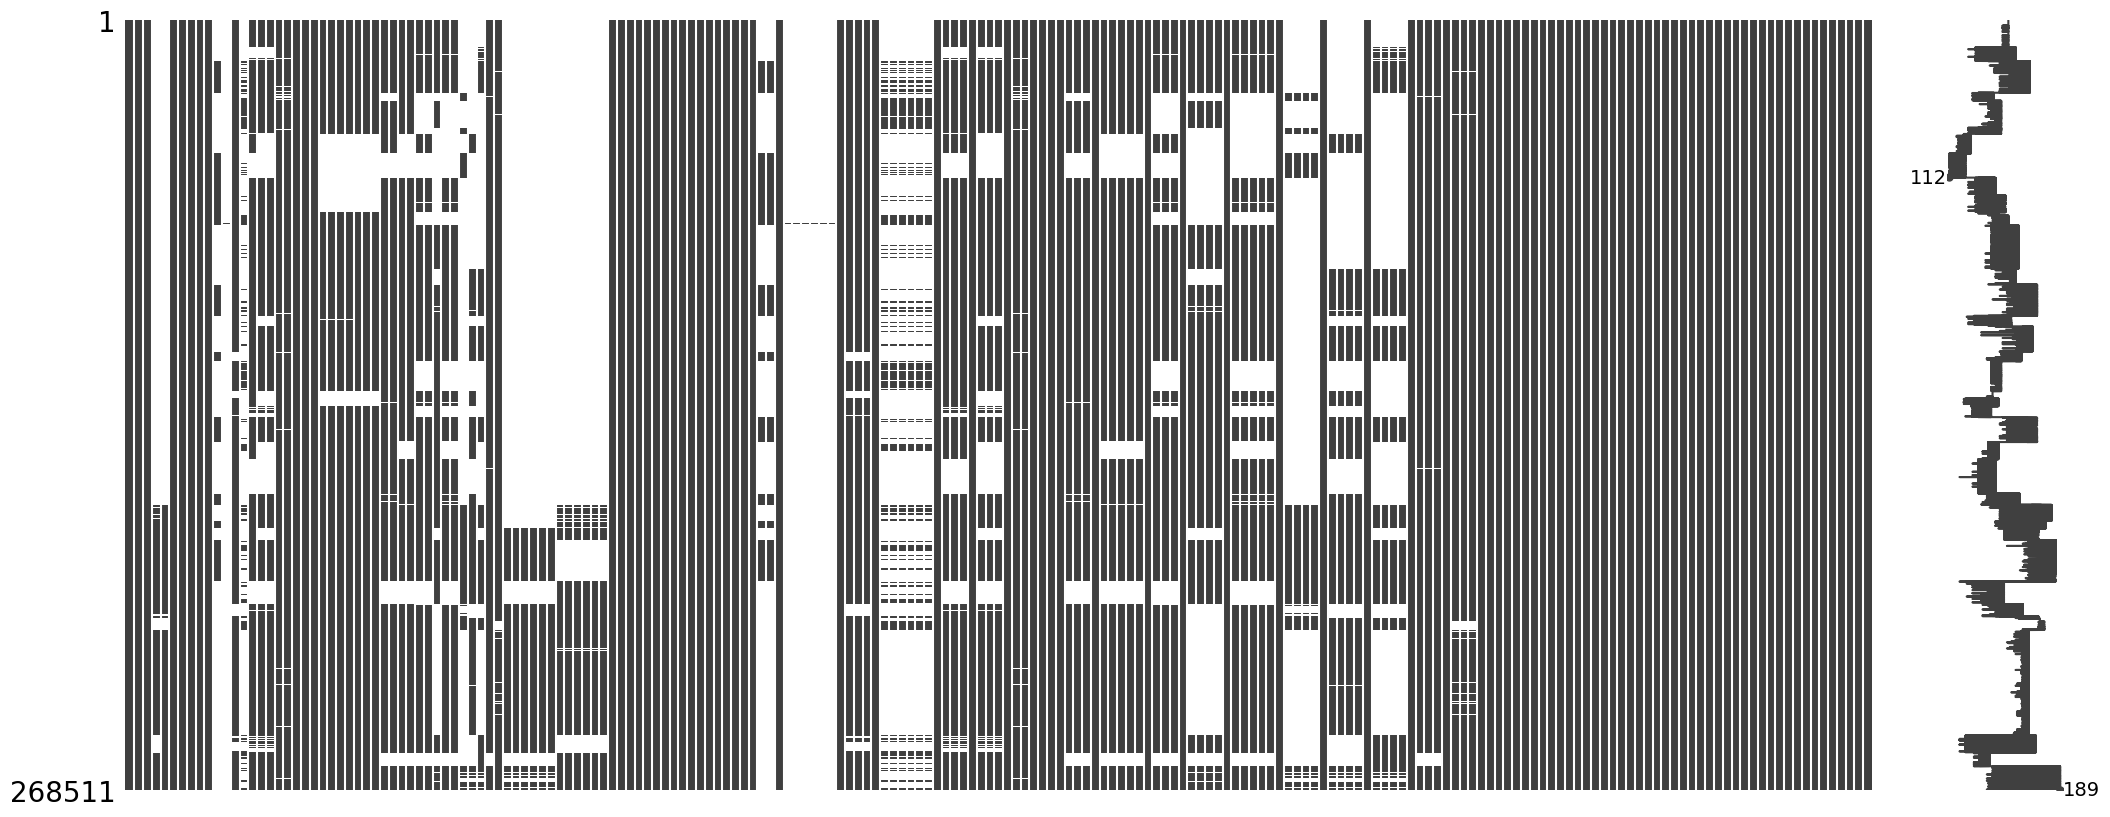

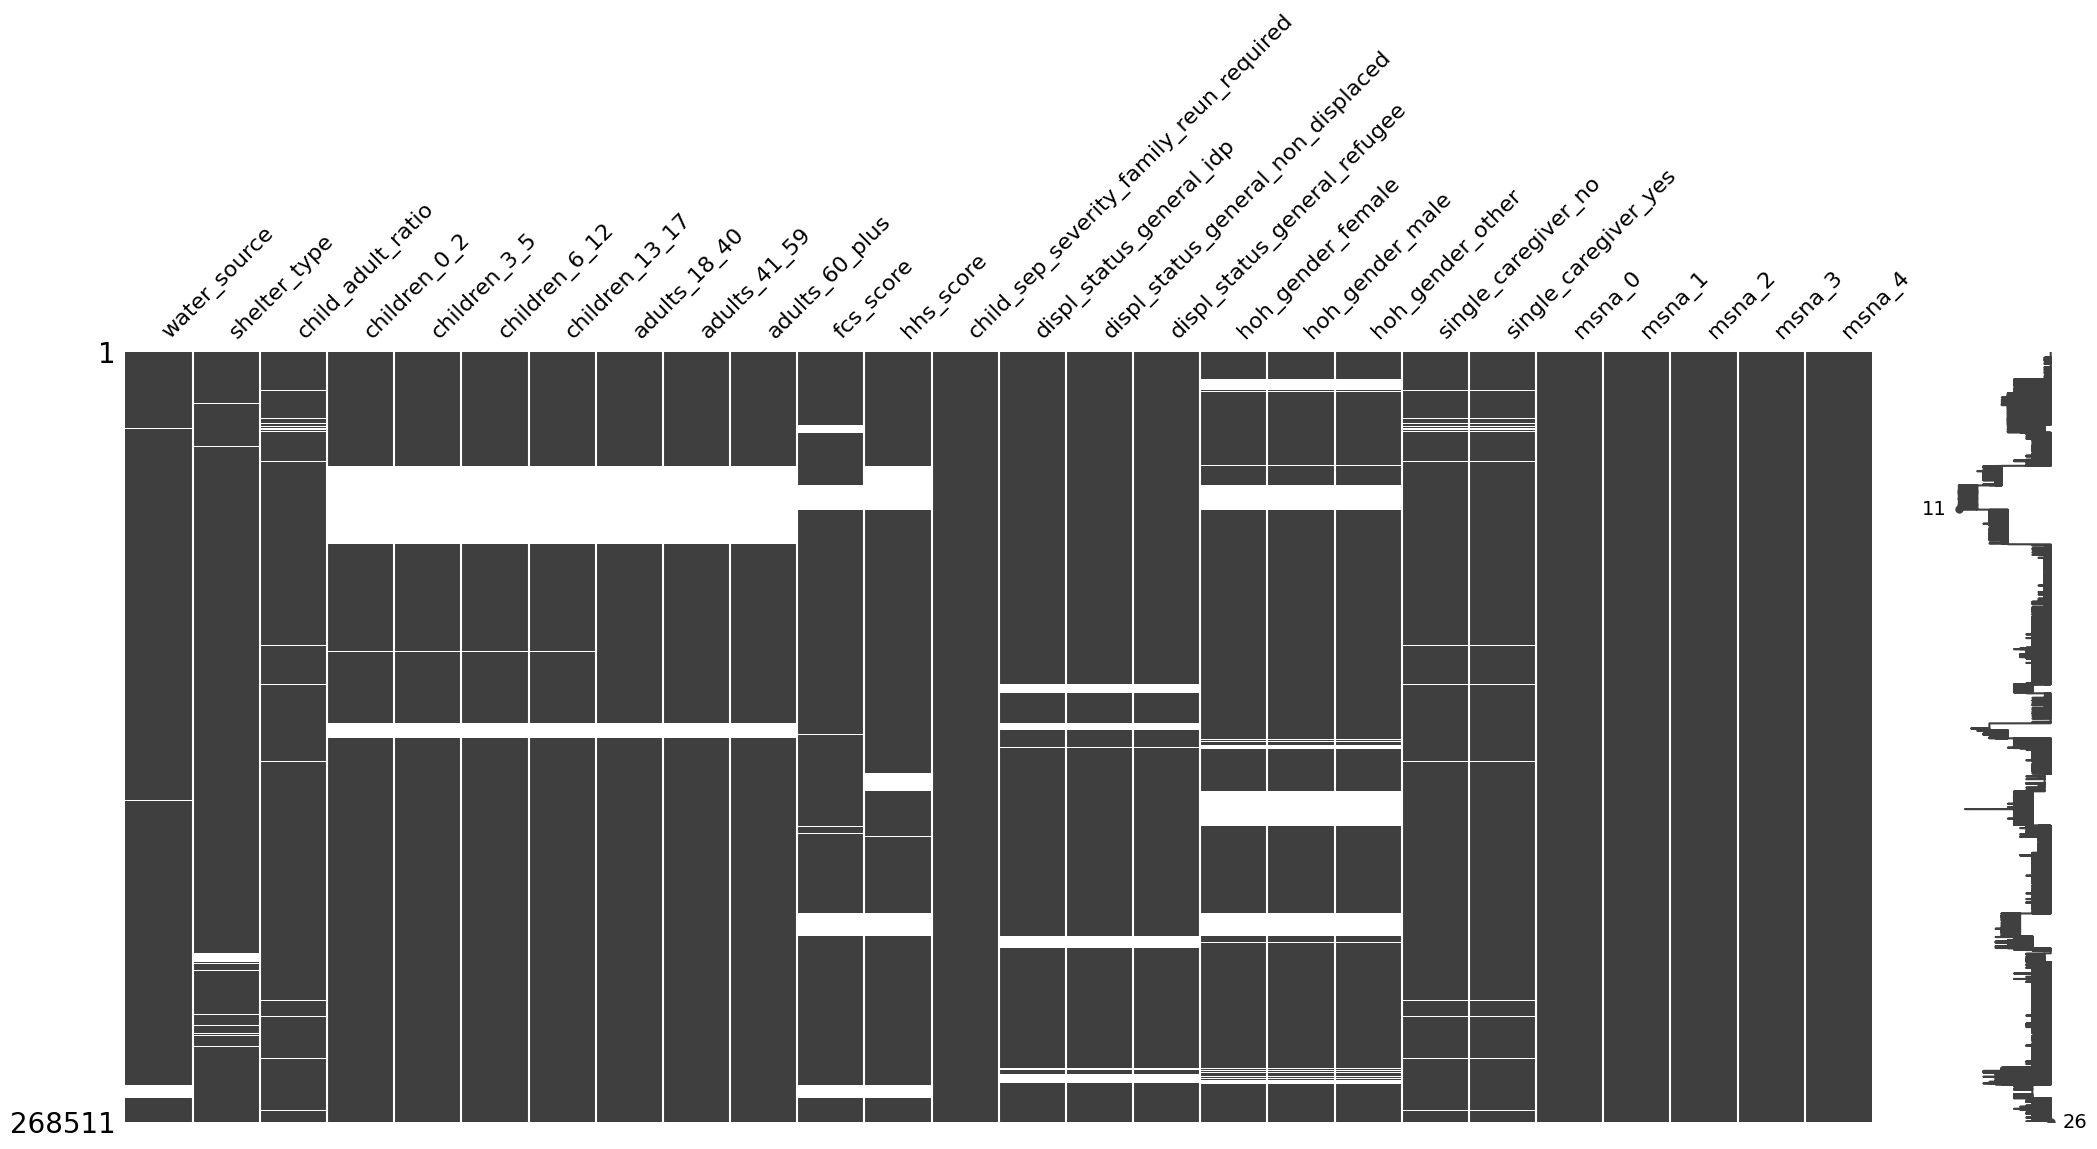


Final DataFrame after dropping unnecessary columns:
<class 'pandas.core.frame.DataFrame'>
Index: 268511 entries, 0 to 329442
Data columns (total 26 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   water_source                             263014 non-null  object 
 1   shelter_type                             262333 non-null  object 
 2   child_adult_ratio                        264081 non-null  float64
 3   children_0_2                             235209 non-null  float64
 4   children_3_5                             235209 non-null  float64
 5   children_6_12                            235209 non-null  float64
 6   children_13_17                           235209 non-null  float64
 7   adults_18_40                             235498 non-null  float64
 8   adults_41_59                             235498 non-null  float64
 9   adults_60_plus                           235498 non-nul

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno

# Define function to display and drop columns based on a condition
def drop_columns_with_condition(df, condition, description):
    columns_to_drop = df.columns[condition].tolist()
    if columns_to_drop:
        print(f"\nDropped columns {description}:")
        print(columns_to_drop)
        return df.drop(columns=columns_to_drop)
    return df

# Filter out rows with missing values in the 'child_sep_severity' column
data_filtered = data.dropna(subset=['child_sep_severity'])
print("\nShape of the filtered DataFrame, without missing values for the response variable:", data_filtered.shape)

# Load variables to consider for the model
vars_analysis = pd.read_csv('vars_analysis.csv')['variable'].tolist()

# Select columns that are relevant for analysis
data_select = data_filtered[vars_analysis].copy()

#  Exclude the two aggregated age variables ###
aggregate_features = ['num_children', 'num_adults']
data_select = data_select.drop(columns=aggregate_features)

# Automatically assign categories to clusters for msna using AgglomerativeClustering
# Specify the number of clusters (n_clusters) or use a distance threshold
n_clusters = 5  # Adjust based on the level of clustering you want

# Fixed the affinity issue by changing 'affinity' to 'metric'
cluster_model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
msna_clusters = cluster_model.fit_predict(target_dist_by_msna)

# Step 5: Create a DataFrame to show the msna categories and their corresponding clusters
clustered_df = pd.DataFrame({'msna': target_dist_by_msna.index, 'cluster': msna_clusters})

# Print the msna categories and their assigned clusters
print(clustered_df)

# Group msna categories by their assigned clusters
grouped_msna = clustered_df.groupby('cluster')['msna'].apply(list)
print(grouped_msna)

# Map cluster assignments back to the original DataFrame (assuming original DataFrame is called 'data_select')
# Create a mapping from msna to clusters
msna_cluster_map = clustered_df.set_index('msna')['cluster'].to_dict()

# Cluster msna variables
data_select['msna_clustered'] = data_select['msna'].map(msna_cluster_map)

# Replace the original 'msna' column
data_select['msna'] = data_select['msna_clustered']
data_select = data_select.drop(columns=['msna_clustered'])

# One-hot encode the 'msna' column with 1/0 instead of True/False
data_select = pd.get_dummies(data_select, columns=['msna'], prefix='msna', dtype=int)

# Identify columns with more than 20% missing values
missing_percentage = data_select.isnull().mean() * 100
columns_with_many_missing = missing_percentage > 20

# Drop columns with more than 20% missing values
data_select = drop_columns_with_condition(data_select, columns_with_many_missing, "with more than 20% missing values")

# Drop columns with zero variance (only one unique value)
zero_variance_condition = data_select.nunique() <= 1
data_select = drop_columns_with_condition(data_select, zero_variance_condition, "with zero variance")

# Identify and drop variables ending with '_NA'
na_columns = [col for col in data_select.columns if col.endswith('_NA')]
data_select = drop_columns_with_condition(data_select, data_select.columns.isin(na_columns), "'_NA' columns")

# Assign the final cleaned data to data_select_na
data_select_na = data_select

# Visualize missing data matrix before dropping columns
msno.matrix(data_filtered)
plt.show()

# Visualize missing data matrix after dropping columns
msno.matrix(data_select_na)
plt.show()

# Display final DataFrame info
print("\nFinal DataFrame after dropping unnecessary columns:")
data_select_na.info()

# Check and display which variables from vars_analysis are no longer in the data
missing_vars = [var for var in vars_analysis if var not in data_select_na.columns]
print("\nVariables from vars_analysis no longer in the data:", missing_vars)


### 2.2 Change Encoding of Ordinal Variables

The script converts one-hot encoded ordinal variables into a more appropriate label-encoded format. It begins by loading a mapping of old one-hot labels and new ordinal labels from `new_labels.csv`, filtering for variables present in the dataset. The script then replaces one-hot encoded values with the corresponding ordinal labels and converts the recoded variables to integer type, ensuring proper handling of missing values. It verifies that all required variables have been recoded and displays the updated data along with the data types of the recoded variables.


In [8]:
# Load the new_labels CSV file and filter for variables present in the data
new_labels = pd.read_csv('new_labels.csv', usecols=['variable', 'label_old', 'label_new'])
new_labels = new_labels[new_labels['variable'].isin(data_select_na.columns)]

print("\nLoaded new_labels DataFrame:")
print(new_labels.head())

# Create a copy of data_select_na to apply changes
data_ord = data_select_na.copy()

# Apply the label mapping to the data_ord DataFrame
for _, row in new_labels.iterrows():
    variable = row['variable']
    label_old = row['label_old']
    label_new = int(row['label_new'])  # Convert label_new to integer
    
    if variable in data_ord.columns:
        data_ord[variable] = data_ord[variable].replace(label_old, label_new)

# Define recoded_variables
recoded_variables = new_labels['variable'].unique()

# Convert the recoded variables to integer type
for variable in recoded_variables:
    if variable in data_ord.columns:
        data_ord[variable] = data_ord[variable].fillna(pd.NA).astype('Int64')  # Fill NaNs with pd.NA before converting

# Check if recoded_variables are in data_ord
variables_in_data_ord = all(variable in data_ord.columns for variable in recoded_variables)
print(f"All recoded variables are in data_ord: {variables_in_data_ord}")

# Identify which variables are not in data_ord
missing_variables = [variable for variable in recoded_variables if variable not in data_ord.columns]
print(f"Variables not in data_ord: {missing_variables}")

# Display the first few rows of the recoded variables in the data_ord DataFrame
print("\nRecoded variables in data_ord DataFrame:")
print(data_ord[recoded_variables].head())

# Display the variable types of the recoded variables
print("\nVariable types of recoded variables:")
print(data_ord[recoded_variables].dtypes)


Loaded new_labels DataFrame:
       variable   label_old  label_new
0  shelter_type    adequate          1
1  shelter_type  inadequate          2
2  shelter_type  no_shelter          3
3  water_source    improved          1
4  water_source  unimproved          2


C:\Users\jasper.linke\AppData\Local\Temp\ipykernel_36336\1119195321.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_ord[variable] = data_ord[variable].replace(label_old, label_new)


All recoded variables are in data_ord: True
Variables not in data_ord: []

Recoded variables in data_ord DataFrame:
   shelter_type  water_source
0             1             1
1             1             1
3             1             1
4             1             1
6             1             2

Variable types of recoded variables:
shelter_type    Int64
water_source    Int64
dtype: object


### 2.4 KNN Imputation of Remaining Missing Values

Next, we use **K-Nearest Neighbors (KNN) imputation** to handle missing values across all columns in the dataset. It first applies the `KNNImputer` to estimate and replace missing values based on the nearest neighbors. After imputation, the missing data is visualized, and the updated dataset with the imputed values is displayed for verification.

In [9]:
import pandas as pd
from sklearn.impute import KNNImputer
import missingno as msno
import matplotlib.pyplot as plt

# Function to apply K-Nearest Neighbors Imputation to all columns
def knn_impute_all_columns(df, n_neighbors=5):
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    return df_imputed

# Apply KNN imputation to all columns
data_na_imp = knn_impute_all_columns(data_ord.copy())

# Visualize missing data matrix
msno.matrix(data_na_imp)
plt.show()

# Display the first few rows of the new dataframe with imputed values
print("\nDataFrame with imputed values in all columns:")
print(data_na_imp.head())

# Display the first few rows of the new dataframe with imputed values
print("\nDataFrame with imputed values in the first column:")
print(data_na_imp.head())

ValueError: could not convert string to float: 'afg-2021'

### 2.5 Standardization

This process standardizes the **numerical variables** in the dataset while preserving categorical and dummy variables. After identifying variable types from `vars_analysis.csv`, only numerical variables are standardized using `StandardScaler` to ensure a mean of 0 and standard deviation of 1. Categorical variables are added back without standardization. The script displays summary statistics before and after standardization and visualizes the distribution of the `num_children` variable with histograms to illustrate the effect of standardization.


Summary statistics before standardization:
       water_source  shelter_type       hoh_age  child_adult_ratio  \
count  99465.000000  99465.000000  99465.000000       99465.000000   
mean       1.462728      1.267829     43.574825           1.529930   
std        0.654146      0.437580     12.462860           1.127265   
min        1.000000      1.000000     15.000000           0.035714   
25%        1.000000      1.000000     34.600000           0.666667   
50%        1.000000      1.000000     42.000000           1.333333   
75%        2.000000      1.800000     51.000000           2.000000   
max        3.000000      3.000000    101.000000          14.000000   

       num_children    num_adults  children_0_2  children_3_5  children_6_12  \
count  99465.000000  99465.000000  99465.000000  99465.000000   99465.000000   
mean       3.195154      2.513970      0.447434      0.646569       1.382878   
std        1.940467      1.286772      0.626657      0.743152       1.234360   
min  

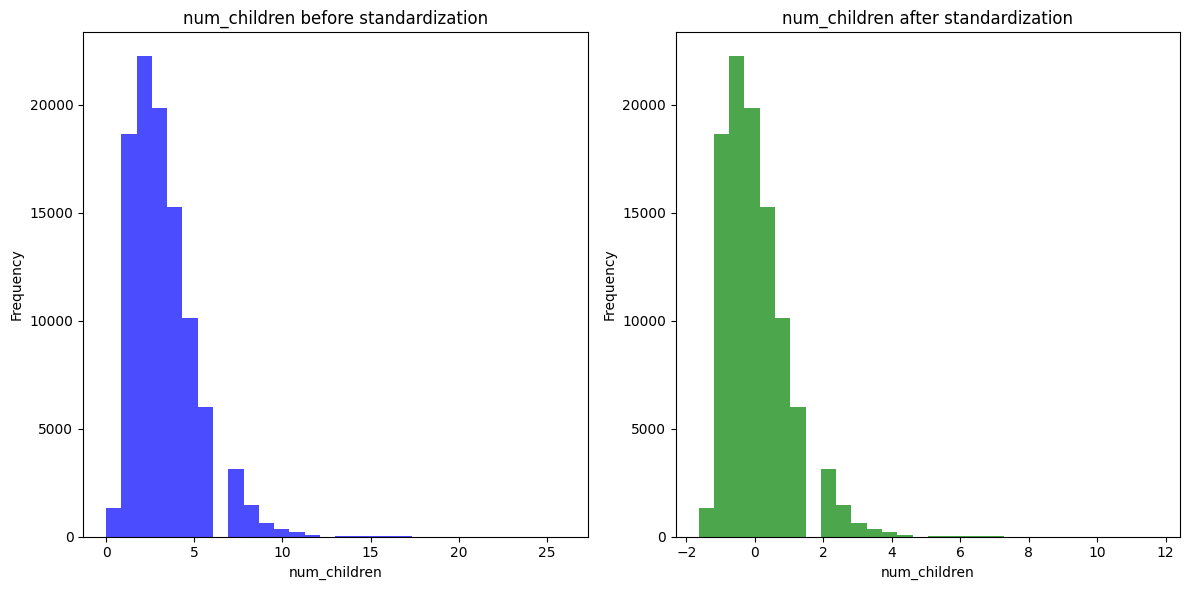

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Load the vars_analysis.csv to identify variable types
vars_analysis = pd.read_csv('vars_analysis.csv', usecols=['variable', 'type'])
dummy_variables = vars_analysis[vars_analysis['type'] == 'dummy']['variable'].tolist()
categorical_variables = vars_analysis[vars_analysis['type'] == 'ordinal']['variable'].tolist()
numerical_variables = vars_analysis[vars_analysis['type'] == 'numerical']['variable'].tolist()

# Filter variables to include only those present in data_dum
dummy_variables = [var for var in dummy_variables if var in data_na_imp.columns]
categorical_variables = [var for var in categorical_variables if var in data_na_imp.columns]
numerical_variables = [var for var in numerical_variables if var in data_na_imp.columns]

# Standardize the numerical variables (excluding dummy variables and categorical variables)
scaler = StandardScaler()
data_stand = data_na_imp.copy()
data_stand[numerical_variables] = scaler.fit_transform(data_stand[numerical_variables])

# Add back the categorical variables without standardizing them
common_categorical_vars = list(set(categorical_variables).intersection(data_na_imp.columns))
data_stand[common_categorical_vars] = data_na_imp[common_categorical_vars]

# Display summary statistics before standardization
print("\nSummary statistics before standardization:")
print(data_na_imp.describe())

# Display summary statistics after standardization
print("\nSummary statistics after standardization:")
print(data_stand.describe())

# Histogram for hoh_age before standardization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data_na_imp['num_children'], bins=30, alpha=0.7, color='blue')
plt.title('num_children before standardization')
plt.xlabel('num_children')
plt.ylabel('Frequency')

# Histogram for num_children after standardization
plt.subplot(1, 2, 2)
plt.hist(data_stand['num_children'], bins=30, alpha=0.7, color='green')
plt.title('num_children after standardization')
plt.xlabel('num_children')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 3. Feature Selection


Performing Correlation Analysis...
Dropped features due to high correlation (threshold = 0.9):
['hoh_gender_male', 'single_caregiver_yes', 'received_assistance_6m_yes']
Number of features after Correlation Analysis: 38

Training LightGBM model for SHAP analysis...
[LightGBM] [Info] Number of positive: 267, number of negative: 69358
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 69625, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Computing SHAP values...


100%|===================| 69290/69625 [02:56<00:00]        


Top 20 features selected based on SHAP values:
['hoh_age', 'rcsi_score', 'msna_drc-2023', 'fcs_score', 'water_source', 'child_adult_ratio', 'children_0_2', 'children_6_12', 'hhs_score', 'fsl_fc_cell', 'msna_bfa-2023', 'msna_ukr-2023', 'children_3_5', 'adults_18_40', 'msna_ner-2023', 'received_assistance_6m_no', 'displ_status_general_non_displaced', 'adults_41_59', 'msna_mli-2023', 'single_caregiver_NA']

Number of features in X_selected: 20

DataFrames 'X_selected.pkl' and 'y.pkl' have been saved as pickle files.

Generating SHAP summary plots...


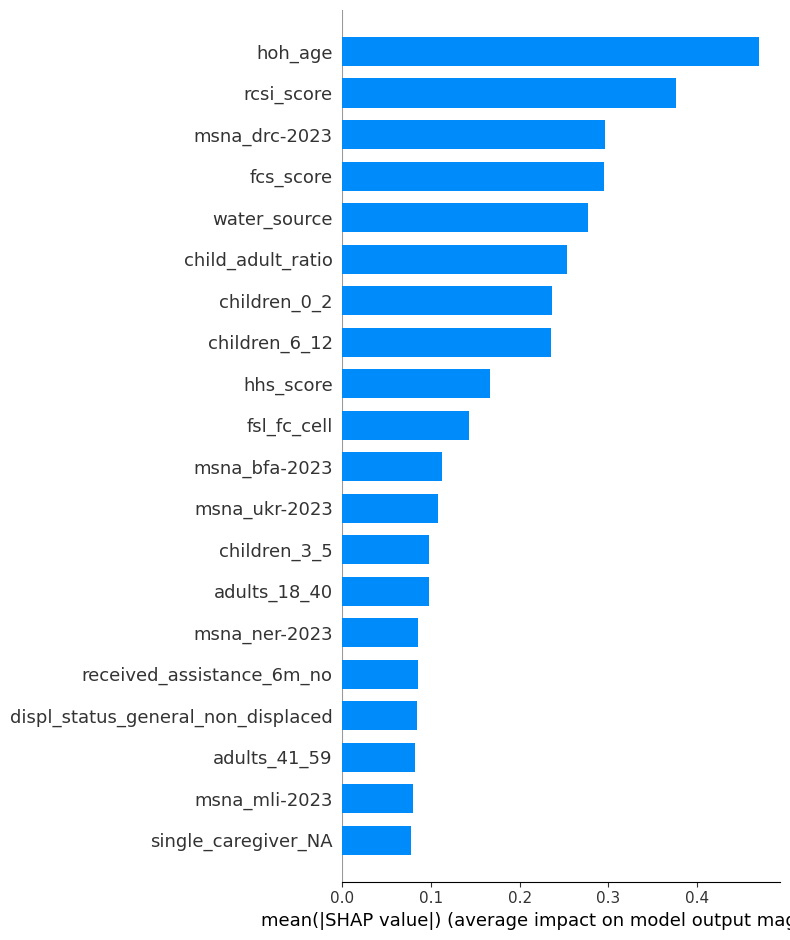

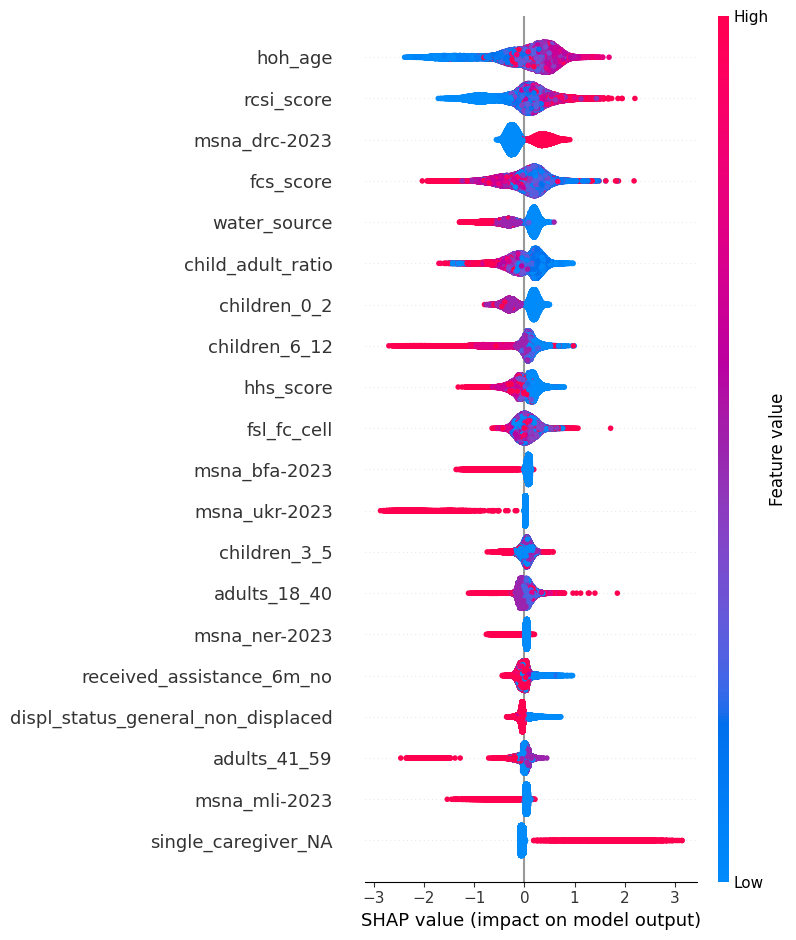


Generating SHAP dependence plots for top features...


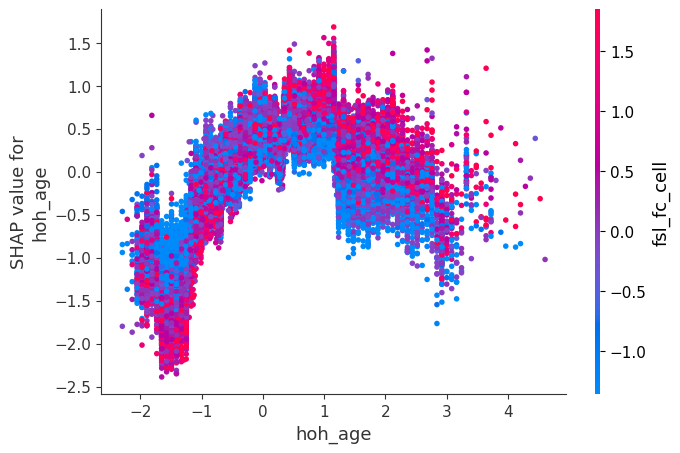

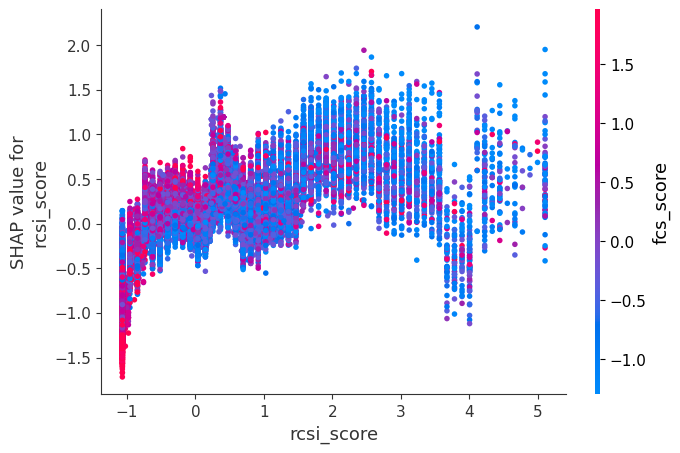

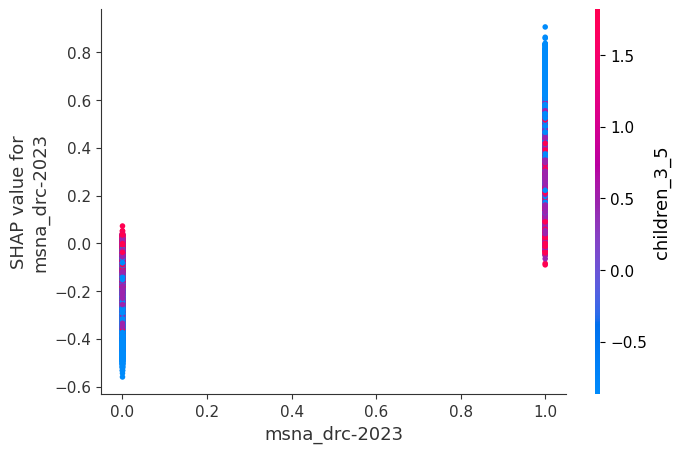

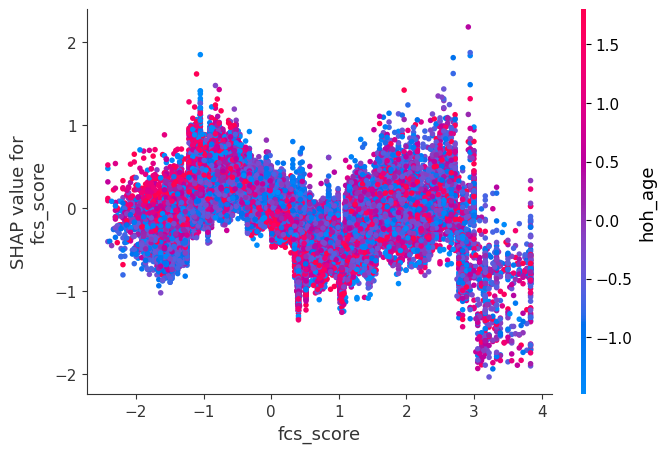

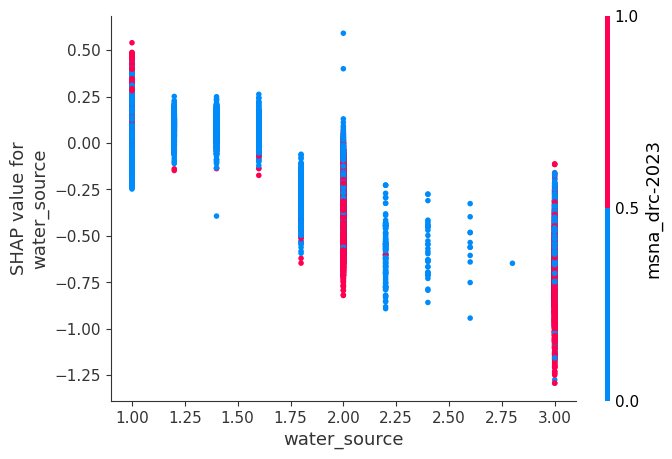

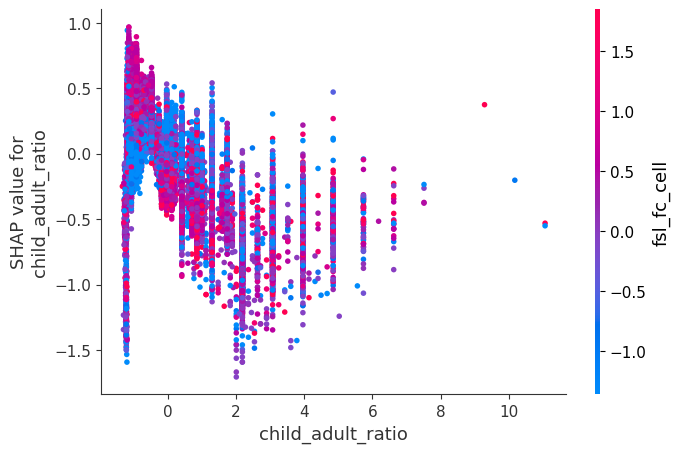

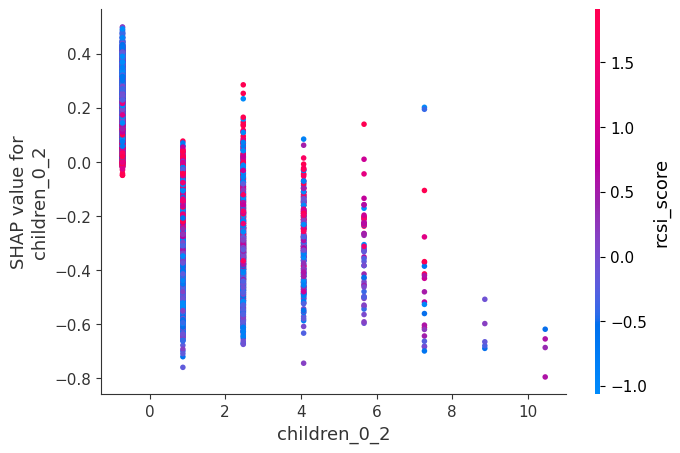

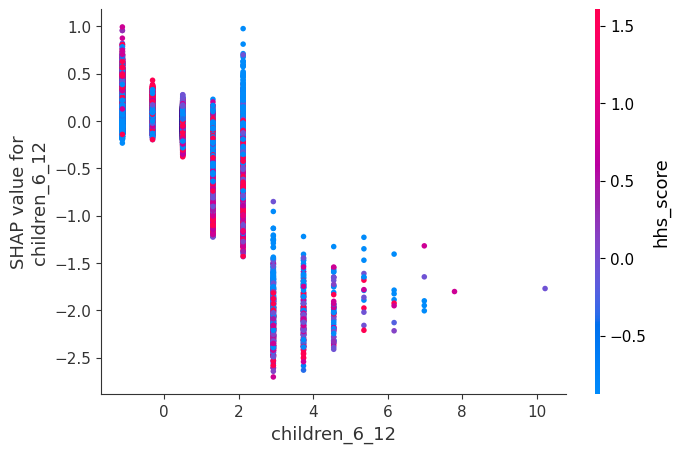

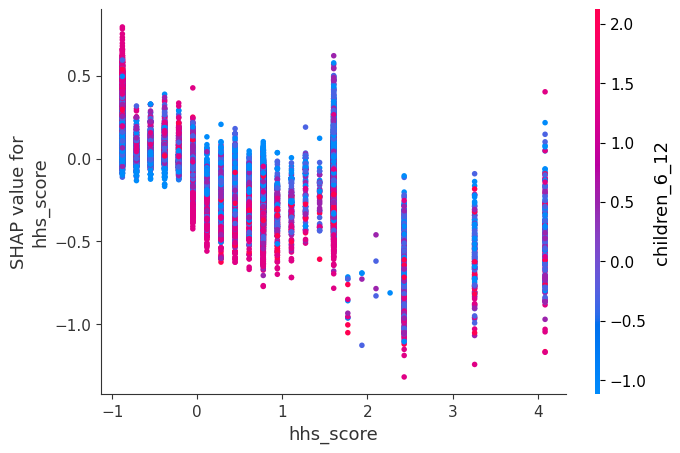

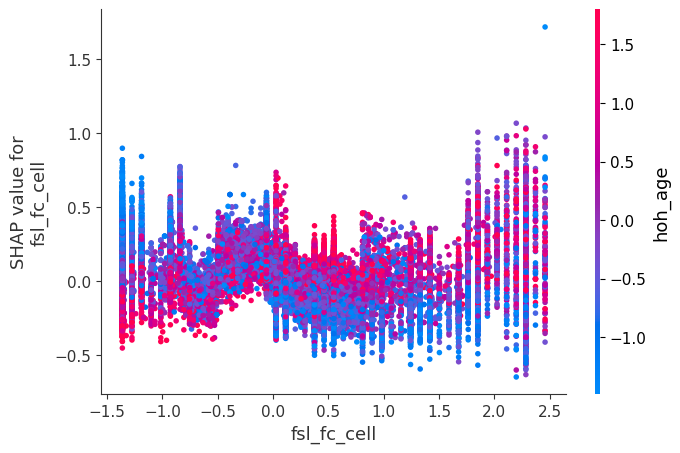

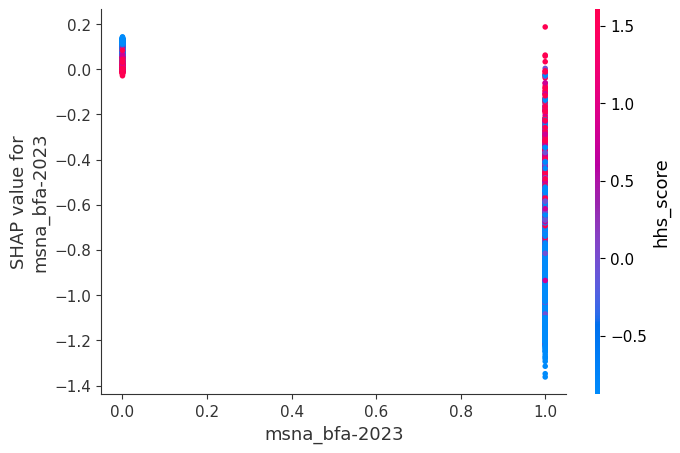

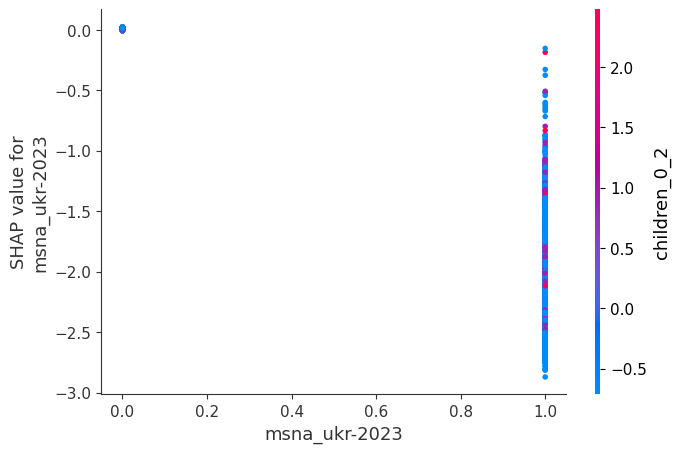

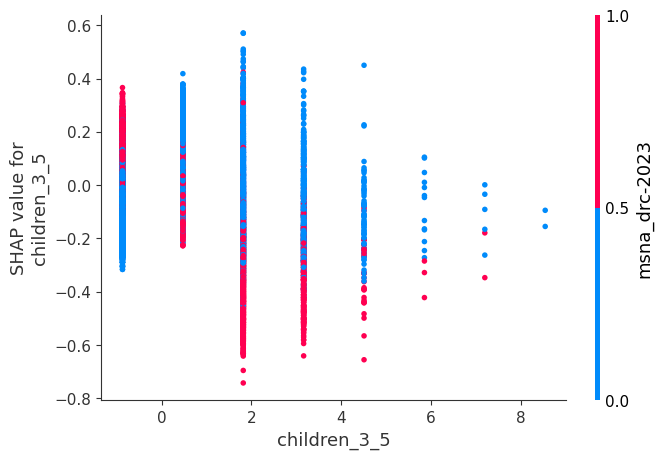

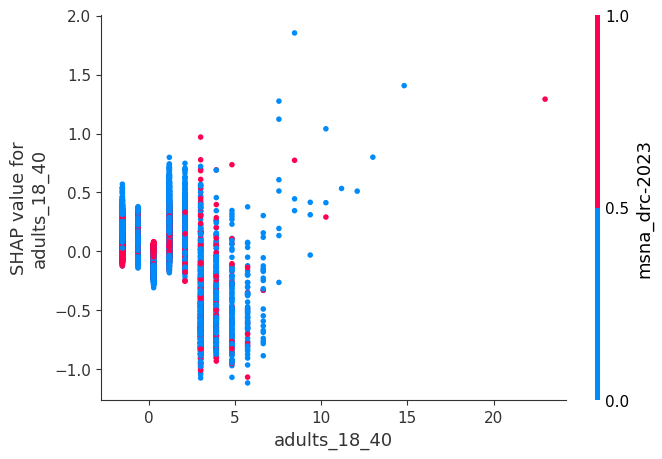

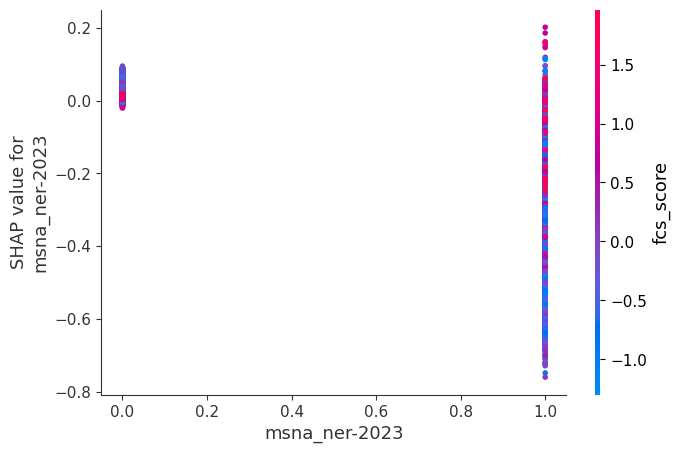

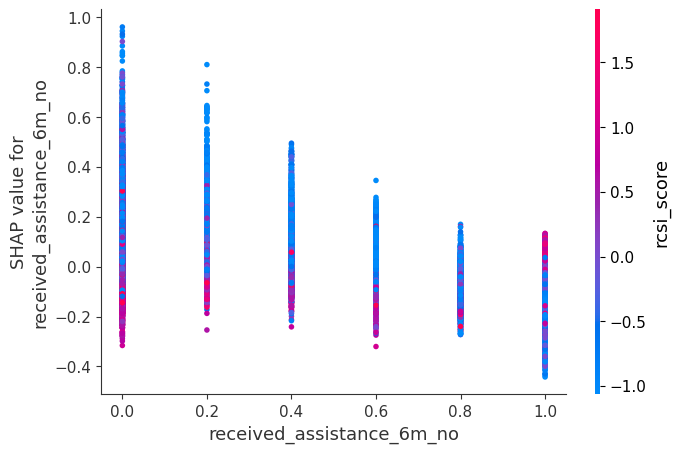

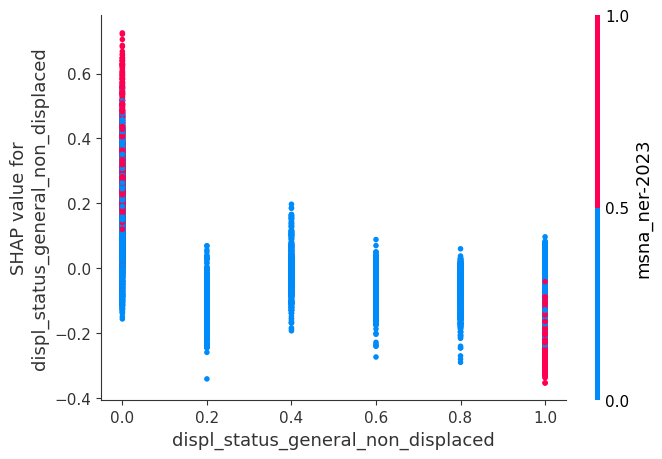

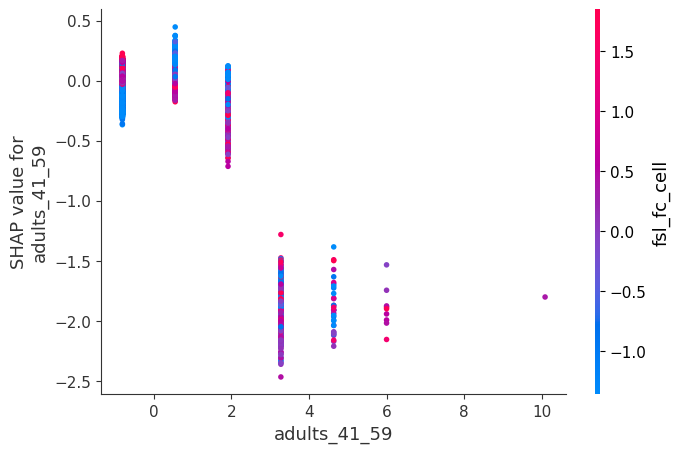

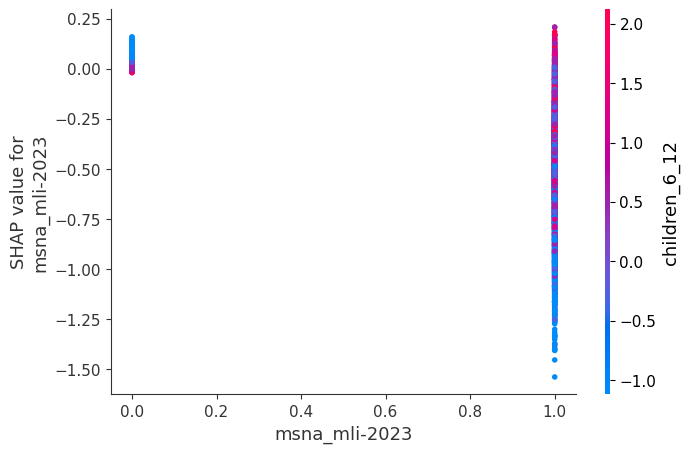

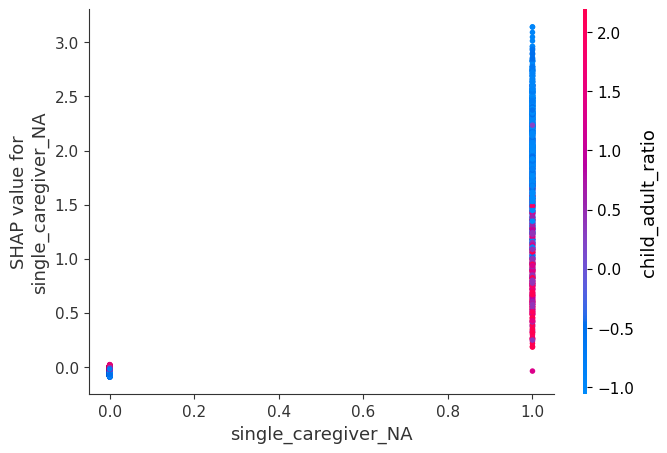


SHAP visualizations have been generated and displayed.


In [18]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import pickle
from sklearn.model_selection import train_test_split

### Create copy of data_stand for feature selection ###
data_fs = data_stand.copy()

### Separate features and target variable ###
X = data_fs.drop(columns=['child_sep_severity_family_reun_required'], errors='ignore')
y = data_fs['child_sep_severity_family_reun_required']

### Ensure Input Data is Correct ###

# Check if features are numeric and have no missing values
def check_numeric(df):
    if not all(df.dtypes.apply(lambda x: np.issubdtype(x, np.number))):
        raise ValueError("All features must be numeric. Please convert categorical variables to numeric format.")

def check_no_missing(df):
    if df.isnull().any().any():
        raise ValueError("Input data contains missing values. Please handle missing data before applying these methods.")

check_numeric(X)
check_no_missing(X)

### 1. Correlation Analysis ###

print("\nPerforming Correlation Analysis...")
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Define the correlation threshold
correlation_threshold = 0.9

# Find features with correlation greater than the threshold
to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
print(f"Dropped features due to high correlation (threshold = {correlation_threshold}):")
print(to_drop)

# Drop the highly correlated features
X_uncorr = X.drop(columns=to_drop)
print(f"Number of features after Correlation Analysis: {X_uncorr.shape[1]}")

### 2. Temporary Data Split for SHAP Analysis ###

# Split the data into a temporary training and testing set
X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(
    X_uncorr, y, test_size=0.3, random_state=42, stratify=y
)

### 3. Train a LightGBM Model for SHAP ###

print("\nTraining LightGBM model for SHAP analysis...")
# Set class_weight='balanced' to handle class imbalance
lgb_model = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
lgb_model.fit(X_temp_train, y_temp_train)

### 4. Compute SHAP Values ###

print("Computing SHAP values...")
explainer = shap.Explainer(lgb_model, X_temp_train)
shap_values = explainer(X_temp_train)

### 5. Calculate Mean Absolute SHAP Values ###

mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
shap_importance = pd.DataFrame({
    'feature': X_uncorr.columns,
    'shap_importance': mean_abs_shap_values
})

# Sort features by SHAP importance
shap_importance.sort_values(by='shap_importance', ascending=False, inplace=True)

### 6. Select Top Features Based on SHAP Values ###

# Define the number of top features to select
num_top_features = 20  # Adjust this number as needed

top_features_shap = shap_importance['feature'].head(num_top_features).tolist()
print(f"\nTop {num_top_features} features selected based on SHAP values:")
print(top_features_shap)

### 7. Create DataFrame with Top Features ###

X_selected = X_uncorr[top_features_shap]
print(f"\nNumber of features in X_selected: {X_selected.shape[1]}")

### 8. Save X_selected and y ###

try:
    with open('X_selected.pkl', 'wb') as f:
        pickle.dump(X_selected, f)
    with open('y.pkl', 'wb') as f:
        pickle.dump(y, f)
    print("\nDataFrames 'X_selected.pkl' and 'y.pkl' have been saved as pickle files.")
except Exception as e:
    print(f"Error saving DataFrames as pickle files: {e}")

### 9. Generate SHAP Summary Plots ###

print("\nGenerating SHAP summary plots...")

# Bar plot of mean absolute SHAP values
shap.summary_plot(
    shap_values.values,
    X_temp_train,
    plot_type="bar",
    max_display=num_top_features
)

# Beeswarm plot to show the distribution of SHAP values
shap.summary_plot(
    shap_values.values,
    X_temp_train,
    max_display=num_top_features
)

### 10. Generate SHAP Dependence Plots for Top Features ###

print("\nGenerating SHAP dependence plots for top features...")

for feature in top_features_shap:
    shap.dependence_plot(
        feature,
        shap_values.values,
        X_temp_train
    )

print("\nSHAP visualizations have been generated and displayed.")


## 4. Data Splitting

In [27]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the saved DataFrames
with open('X_selected.pkl', 'rb') as f:
    X_selected = pickle.load(f)
with open('y.pkl', 'rb') as f:
    y = pickle.load(f)

### 1. Separate the Data into Class 0 (Normal) and Class 1 (Anomalies) ###

# Create DataFrames for class 0 (normal cases) and class 1 (anomalies)
X_class0 = X_selected[y == 0]
y_class0 = y[y == 0]

X_class1 = X_selected[y == 1]
y_class1 = y[y == 1]

print(f"Total samples in Class 0 (Normal): {X_class0.shape[0]}")
print(f"Total samples in Class 1 (Anomalies): {X_class1.shape[0]}")

### 2. Split Class 0 Data into Training, Validation, and Test Sets ###

# Split class 0 data into training (80%) and temporary set (20%)
X_train_class0, X_temp_class0, y_train_class0, y_temp_class0 = train_test_split(
    X_class0, y_class0, test_size=0.2, random_state=42
)

# Further split the temporary class 0 data into validation (10%) and test (10%) sets
X_val_class0, X_test_class0, y_val_class0, y_test_class0 = train_test_split(
    X_temp_class0, y_temp_class0, test_size=0.5, random_state=42
)

print("\nClass 0 Data Splits:")
print(f"  Training samples: {X_train_class0.shape[0]}")
print(f"  Validation samples: {X_val_class0.shape[0]}")
print(f"  Test samples: {X_test_class0.shape[0]}")

### 3. Split Class 1 Data into Validation and Test Sets ###

# Since we don't use anomalies for training, split class 1 data into validation and test sets
# We'll split equally, but you can adjust the proportion as needed
X_val_class1, X_test_class1, y_val_class1, y_test_class1 = train_test_split(
    X_class1, y_class1, test_size=0.5, random_state=42
)

print("\nClass 1 Data Splits:")
print(f"  Validation samples: {X_val_class1.shape[0]}")
print(f"  Test samples: {X_test_class1.shape[0]}")

### 4. Combine Class 0 and Class 1 Data for Validation and Test Sets ###

# Validation Set: Combine class 0 and class 1 validation data
X_val = pd.concat([X_val_class0, X_val_class1])
y_val = pd.concat([y_val_class0, y_val_class1])

# Test Set: Combine class 0 and class 1 test data
X_test = pd.concat([X_test_class0, X_test_class1])
y_test = pd.concat([y_test_class0, y_test_class1])

# Save the validation and test data as pickle files
with open('X_val.pkl', 'wb') as f:
    pickle.dump(X_val, f)
with open('y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)
with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

# Ensure the indices are aligned
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

### 5. Set Training Data (Only Class 0) ###

X_train = X_train_class0
y_train = y_train_class0

# Save the training data as pickle files
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)

### 6. Print the Structure of the Resulting Splits ###

print("\nTraining Set (Only Class 0 - Normal Cases)")
print(f"  Features: {X_train.shape[1]}")
print(f"  Samples: {X_train.shape[0]}")
print(f"  Class 0: {np.sum(y_train == 0)}")
print(f"  Class 1: {np.sum(y_train == 1)}")  # Should be 0

print("\nValidation Set (Class 0 and Class 1)")
print(f"  Features: {X_val.shape[1]}")
print(f"  Samples: {X_val.shape[0]}")
print(f"  Class 0: {np.sum(y_val == 0)}")
print(f"  Class 1: {np.sum(y_val == 1)}")

print("\nTest Set (Class 0 and Class 1)")
print(f"  Features: {X_test.shape[1]}")
print(f"  Samples: {X_test.shape[0]}")
print(f"  Class 0: {np.sum(y_test == 0)}")
print(f"  Class 1: {np.sum(y_test == 1)}")


Total samples in Class 0 (Normal): 99084
Total samples in Class 1 (Anomalies): 381

Class 0 Data Splits:
  Training samples: 79267
  Validation samples: 9908
  Test samples: 9909

Class 1 Data Splits:
  Validation samples: 190
  Test samples: 191

Training Set (Only Class 0 - Normal Cases)
  Features: 20
  Samples: 79267
  Class 0: 79267
  Class 1: 0

Validation Set (Class 0 and Class 1)
  Features: 20
  Samples: 10098
  Class 0: 9908
  Class 1: 190

Test Set (Class 0 and Class 1)
  Features: 20
  Samples: 10100
  Class 0: 9909
  Class 1: 191


## 5. Model Selection

In [34]:
import pickle
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

# Load the training data (assuming only class 0 is used for training)
with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)  # Should be only class 0 (normal data)

# 1. Define Base Anomaly Detection Models (Unsupervised)
models = {
    'isolation_forest': IsolationForest(contamination=0.003, random_state=42),  # Adjusted for 0.3% anomaly rate
    'one_class_svm': OneClassSVM(kernel='rbf', nu=0.003, gamma='scale'),  # Adjusted nu for 0.3% anomaly rate
    'local_outlier_factor': LocalOutlierFactor(n_neighbors=20, contamination=0.003, novelty=True)  # Adjusted for 0.3% anomaly rate
}

# Train each model
trained_models = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train)  # LOF with novelty=True allows using fit for training and predict on test
    trained_models[model_name] = model

# Save the trained models to a pickle file
with open('trained_models.pkl', 'wb') as f:
    pickle.dump(trained_models, f)

print("\nTraining complete. Models saved to 'trained_models.pkl'.")


Training isolation_forest...
Training one_class_svm...
Training local_outlier_factor...

Training complete. Models saved to 'trained_models.pkl'.


## 6. Model Evaluation

In [35]:
import pickle
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the trained models
with open('trained_models.pkl', 'rb') as f:
    trained_models = pickle.load(f)

# Load the validation data
with open('X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)
with open('y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)  # Contains both normal and anomaly instances

# Evaluate each model
best_f1_score = 0
best_model_name = None

for model_name, model in trained_models.items():
    print(f"Evaluating {model_name}...")
    y_pred = model.predict(X_val)
    y_pred_binary = np.where(y_pred == -1, 1, 0)  # Adjust if necessary

    # Calculate and print metrics
    precision = precision_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)
    f1 = f1_score(y_val, y_pred_binary)
    
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_name = model_name

# Save the best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(trained_models[best_model_name], f)

print(f"\nBest model: {best_model_name} with F1-Score: {best_f1_score:.4f}")

Evaluating isolation_forest...
Precision: 0.1379, Recall: 0.0211, F1-Score: 0.0365
Evaluating one_class_svm...
Precision: 0.1026, Recall: 0.0211, F1-Score: 0.0349
Evaluating local_outlier_factor...


c:\Users\jasper.linke\Python-Projects\child_sep_ml\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Precision: 0.0323, Recall: 0.0053, F1-Score: 0.0090

Best model: isolation_forest with F1-Score: 0.0365


## 7. Model Retraining

In [36]:
import pickle
import pandas as pd

# Load the training and validation data
with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open('X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)
with open('y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)

# Combine the training and validation sets for final retraining
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

# Load the best model from validation
with open('best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Retrain the best model on the combined training and validation set
print("Retraining the best model on the combined training and validation sets...")
best_model.fit(X_combined, y_combined)

# Save the retrained model
with open('retrained_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Retrained model saved as 'retrained_model.pkl'.")



Retraining the best model on the combined training and validation sets...
Retrained model saved as 'retrained_model.pkl'.


## 8. Model Testing

Test Accuracy: 0.9785
Precision: 0.1389, Recall: 0.0262, F1-Score: 0.0441

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      9909
         1.0       0.14      0.03      0.04       191

    accuracy                           0.98     10100
   macro avg       0.56      0.51      0.52     10100
weighted avg       0.97      0.98      0.97     10100


Confusion Matrix:
[[9878   31]
 [ 186    5]]


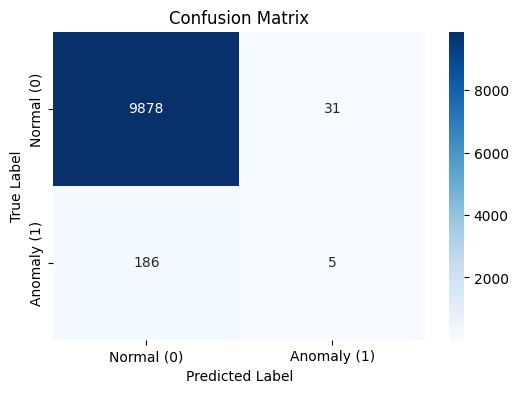

In [37]:
import pickle
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the retrained model
with open('retrained_model.pkl', 'rb') as f:
    retrained_model = pickle.load(f)

# Load the test data
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

# Make predictions on the test set
y_pred = retrained_model.predict(X_test)

# Adjust predictions for anomaly detection models (if applicable)
y_pred_binary = np.where(y_pred == -1, 1, 0)

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
print("\nConfusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal (0)', 'Anomaly (1)'], yticklabels=['Normal (0)', 'Anomaly (1)'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

### Test Set Performance Interpretation

## 10. Interpreting the Model with SHAP

We use **SHAP (SHapley Additive exPlanations)** to identify the factors that most influence child separation requiring family reunification. SHAP is a model-agnostic tool that works for both tree-based models (Random Forest, XGBoost) and linear models (Logistic Regression).

**Key Steps:**
1. **Initialize SHAP Explainer**: Use `TreeExplainer` for tree-based models or `LinearExplainer` for linear models.
2. **Calculate SHAP Values**: These values show the impact of each feature on the model's predictions.
3. **Global Feature Importance**: The SHAP **summary plot** ranks features by their overall influence on the model.
4. **Local Feature Importance**: SHAP can also explain individual predictions using **force plots**.

SHAP helps us understand both global trends and individual predictions, making it a powerful tool for interpreting model behavior and identifying key factors driving outcomes.


 99%|===================| 9975/10100 [00:43<00:00]        

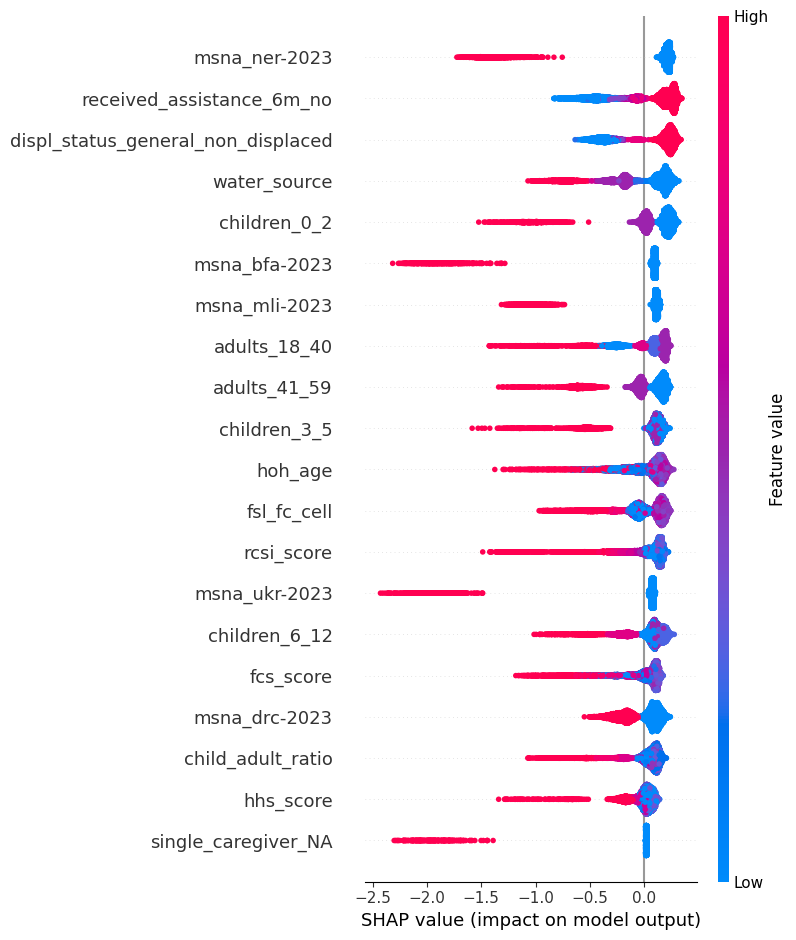

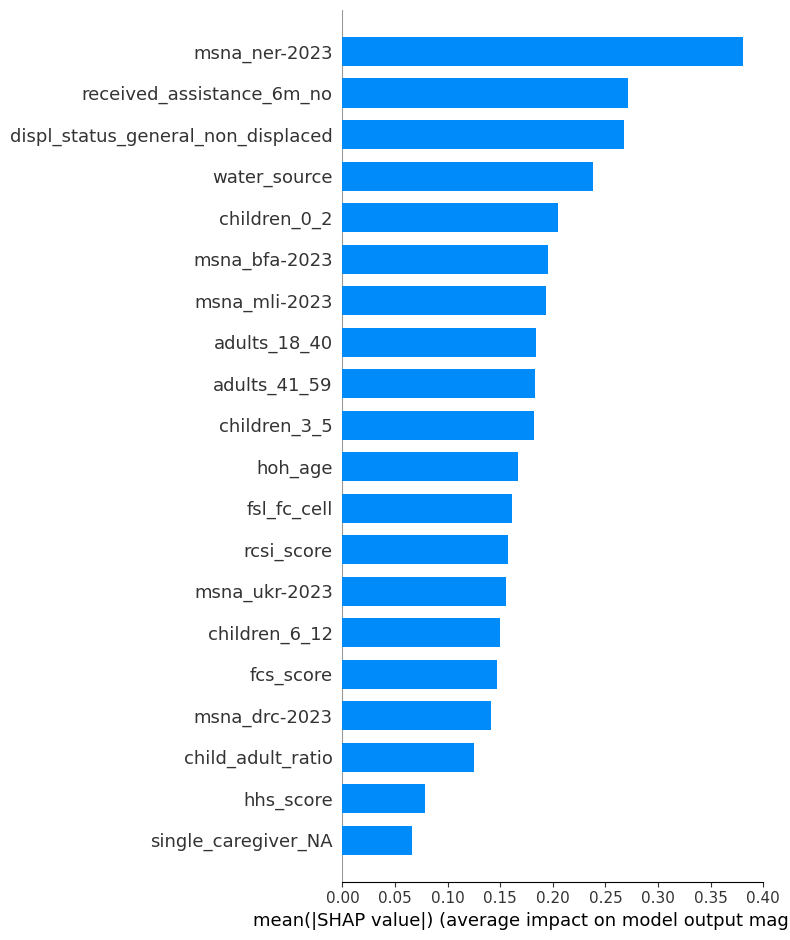

Most important feature: msna_ner-2023


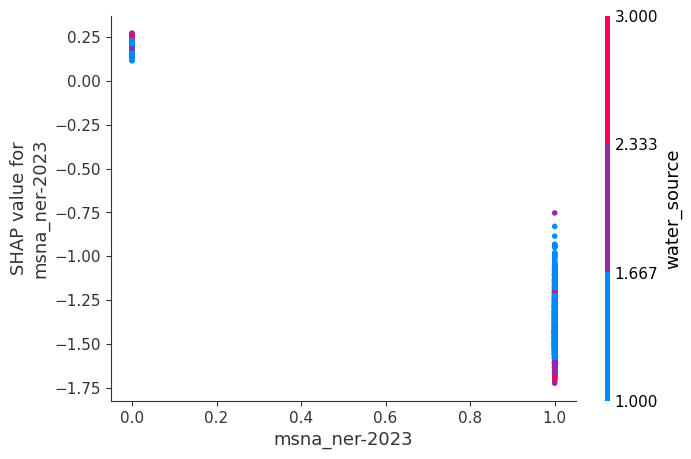

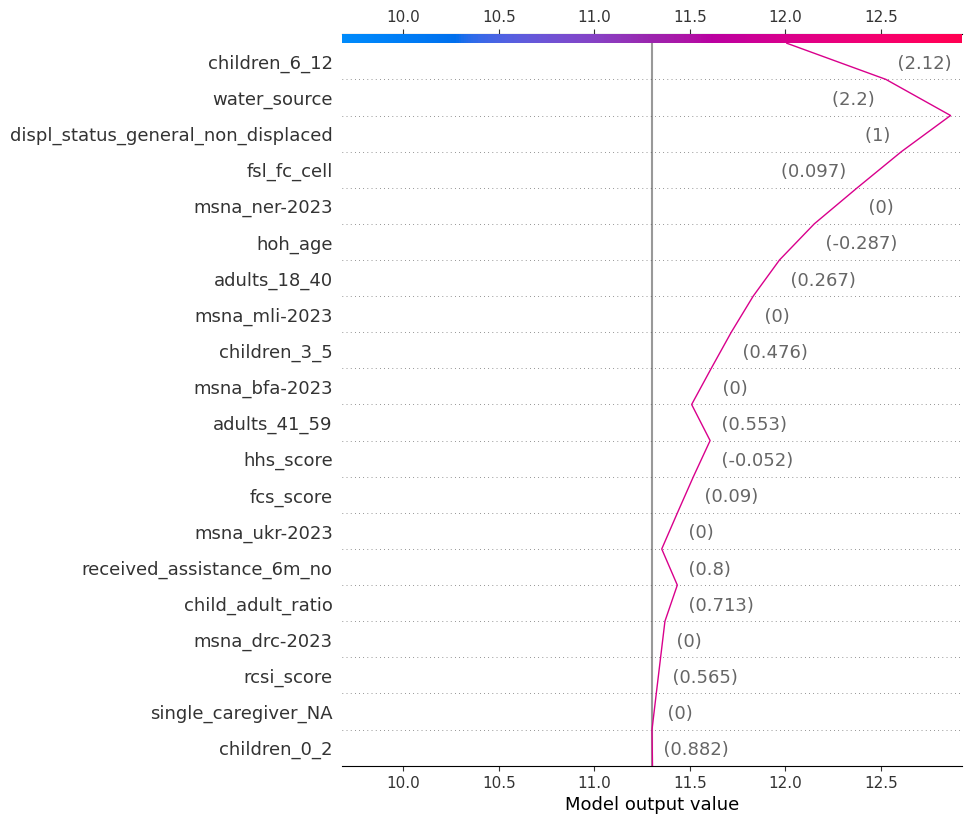

In [38]:
import shap
import numpy as np
import pickle

# Load the retrained best model
with open('retrained_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Load the test data
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

# Load the training data (to match columns, and for the explainer setup)
with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

# Initialize the SHAP explainer (use KernelExplainer if the model doesn't support linear explanations)
explainer = shap.Explainer(best_model, X_test)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Global feature importance plot (original summary plot)
shap.summary_plot(shap_values.values, X_test, feature_names=X_train.columns)

# 1. Feature Importance Bar Plot
shap.summary_plot(shap_values.values, X_test, feature_names=X_train.columns, plot_type="bar")

# Dynamically identify the most important feature based on mean absolute SHAP value
mean_shap_values = np.abs(shap_values.values).mean(axis=0)
most_important_feature = X_train.columns[np.argmax(mean_shap_values)]
print(f"Most important feature: {most_important_feature}")

# 2. SHAP Dependence Plot for the most important feature
shap.dependence_plot(most_important_feature, shap_values.values, X_test)

# 3. SHAP Force Plot (Local Explanation)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0], X_test.iloc[0])

# 4. SHAP Decision Plot
shap.decision_plot(explainer.expected_value, shap_values.values[0], X_test.iloc[0], feature_names=list(X_train.columns))
